In [1]:
pip install tensorflow numpy pandas matplotlib opencv-python

Epoch 1/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 10s 10s/step - loss: 0.0263 - mae: 0.1541 - val_loss: 0.0134 - val_mae: 0.0935
Epoch 2/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 578ms/step - loss: 0.0118 - mae: 0.0963 - val_loss: 0.0180 - val_mae: 0.1149
Epoch 3/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 525ms/step - loss: 0.0184 - mae: 0.1174 - val_loss: 0.0048 - val_mae: 0.0683
Epoch 4/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 499ms/step - loss: 0.0032 - mae: 0.0464 - val_loss: 0.0085 - val_mae: 0.0686
Epoch 5/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 592ms/step - loss: 0.0064 - mae: 0.0728 - val_loss: 0.0084 - val_mae: 0.0684
Epoch 6/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 712ms/step - loss: 0.0058 - mae: 0.0681 - val_loss: 0.0069 - val_mae: 0.0684
Epoch 7/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 503ms/step - loss: 0.0040 - mae: 0.0548 - val_loss: 0.0055 - val_mae: 0.0683
Epoch 8/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 473ms/step - loss: 0.0042 - mae: 0.0606 - val_loss: 0.0047 - val_mae: 0.0682
Epoch 9/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 501ms/step - loss: 0.0029 - mae: 0

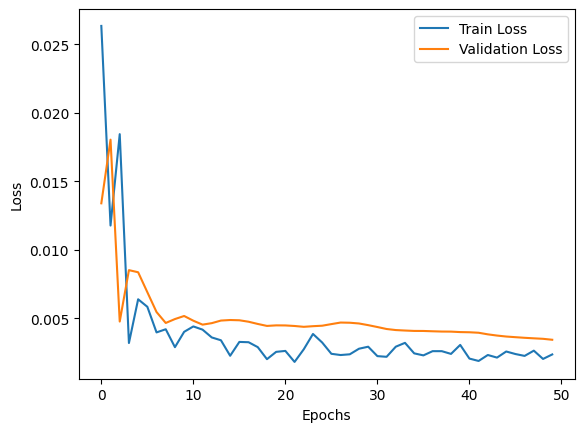

In [2]:
import numpy as np
import pandas as pd
import os
import cv2
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, LSTM, Dense, Dropout, Concatenate
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

# Set paths
aqi_file_path = "/content/AQICities22-25(1).csv"
image_folder_path = "/content/drive/MyDrive/Data_AQI_NPY"

# Load AQI Time-Series Data
df = pd.read_csv(aqi_file_path)
df['Date'] = pd.to_datetime(df['Date'], format='%Y-%m-%d %H:%M:%S', errors='coerce')
df.set_index('Date', inplace=True)

# Keep only relevant AQI features
features = ['PM2.5', 'PM10', 'NO2', 'CO', 'Ozone']
df = df[features]

# Normalize AQI Data
scaler = MinMaxScaler()
df_scaled = scaler.fit_transform(df)

# Convert to supervised learning format (LSTM input)
def create_sequences(data, seq_length=30):
    X, y = [], []
    for i in range(len(data) - seq_length):
        X.append(data[i:i+seq_length])
        y.append(data[i+seq_length][0])
    return np.array(X), np.array(y)

X_time_series, y = create_sequences(df_scaled)

# Load Satellite Images
image_size = (128, 128)
image_files = sorted(os.listdir(image_folder_path))
X_images = []

for img_file in image_files:
    img_path = os.path.join(image_folder_path, img_file)
    img = np.load(img_path)

    if img.shape[:2] != image_size:
        img = cv2.resize(img, image_size)
    if len(img.shape) == 2:
        img = cv2.cvtColor(img, cv2.COLOR_GRAY2BGR)

    img = img / 255.0
    X_images.append(img)

X_images = np.array(X_images)

# Ensure X_time_series and X_images have same number of samples
min_samples = min(len(X_time_series), len(X_images))
X_time_series, y, X_images = X_time_series[:min_samples], y[:min_samples], X_images[:min_samples]

# Train-test split
X_train_time, X_test_time, X_train_img, X_test_img, y_train, y_test = train_test_split(
    X_time_series, X_images, y, test_size=0.2, random_state=42
)

# CNN Model for Satellite Images
image_input = Input(shape=(128, 128, 3))
x = Conv2D(32, (3,3), activation='relu', padding='same')(image_input)
x = MaxPooling2D((2,2))(x)
x = Conv2D(64, (3,3), activation='relu', padding='same')(x)
x = MaxPooling2D((2,2))(x)
x = Flatten()(x)
x = Dense(128, activation='relu')(x)
image_output = Dropout(0.3)(x)

# LSTM Model for Time-Series Data
time_input = Input(shape=(30, len(features)))
y = LSTM(64, return_sequences=True)(time_input)
y = LSTM(32)(y)
y = Dense(128, activation='relu')(y)
time_output = Dropout(0.3)(y)

# Merge CNN and LSTM outputs
merged = Concatenate()([image_output, time_output])
merged = Dense(64, activation='relu')(merged)
merged = Dense(32, activation='relu')(merged)
output = Dense(1, activation='linear')(merged)

# Define the final model
model = Model(inputs=[image_input, time_input], outputs=output)
model.compile(optimizer='adam', loss='mse', metrics=['mae'])

# Train the model
history = model.fit(
    [X_train_img, X_train_time], y_train,
    validation_data=([X_test_img, X_test_time], y_test),
    epochs=50,
    batch_size=32
)

# Evaluate the model
mse, mae = model.evaluate([X_test_img, X_test_time], y_test)
print(f"Test MSE: {mse}")
print(f"Test MAE: {mae}")

# Plot training history
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

# Save the trained model
model.save("/content/drive/MyDrive/CNN2_LSTM_AQI_Model.keras")


In [5]:
import os

# Change path accordingly
model_path = "/content/drive/My Drive/CNN2_LSTM_AQI_Model.keras"

if os.path.exists(model_path):
    print("✅ Model is saved successfully!")
else:
    print("❌ Model not found. Check your path!")


✅ Model is saved successfully!


In [4]:
!pip install gradio --quiet

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.5/46.5 MB 18.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 322.2/322.2 kB 19.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 95.2/95.2 kB 7.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.3/11.3 MB 74.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 72.0/72.0 kB 4.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.3/62.3 kB 5.0 MB/s eta 0:00:00


In [6]:
import gradio as gr
import numpy as np
import cv2
import tensorflow as tf

# Load trained model
model = tf.keras.models.load_model("/content/drive/MyDrive/CNN2_LSTM_AQI_Model.keras")

# Function to preprocess and predict AQI
def predict_aqi(image_file, feature_input):
    try:
        # ---- 📌 Handle Image Input (Supports .npy and Image Files) ----
        if image_file is not None:
            if image_file.name.endswith(".npy"):
                # Load .npy file (grayscale image with shape (128, 128))
                img = np.load(image_file.name)

                # Check if image is grayscale
                if len(img.shape) == 2:
                    img = np.stack([img] * 3, axis=-1)  # Convert to 3-channel RGB
            else:
                # Load as a normal image
                img = cv2.imread(image_file.name)
                img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Convert to RGB

            # Resize and normalize
            img = cv2.resize(img, (128, 128)) / 255.0
            img = img.reshape(1, 128, 128, 3)
        else:
            img = np.zeros((1, 128, 128, 3))  # Default blank image

        # ---- 📌 Handle Time-Series Numerical Input ----
        if feature_input.strip():
            try:
                features_list = [float(i) for i in feature_input.split(",")]
                features_list = features_list[:150] + [0.0] * (150 - len(features_list))  # Ensure 150 values
                features_array = np.array(features_list).reshape(1, 30, 5)
            except:
                return "Error: Invalid numerical input. Enter AQI values separated by commas."
        else:
            features_array = np.zeros((1, 30, 5))

        # ---- 📌 Make Prediction ----
        prediction = model.predict([img, features_array])[0][0]
        return f"Predicted AQI: {prediction * 500:.2f}"

    except Exception as e:
        return f"Error: {str(e)}"

# ---- 📌 Deploy with Gradio ----
gr.Interface(
    fn=predict_aqi,
    inputs=[
        gr.File(label="Upload Satellite Image (.png, .jpg, .tif, or .npy)"),  # File Upload (Supports .npy)
        gr.Textbox(label="Enter AQI Values (comma-separated, Optional)")  # Numerical Input
    ],
    outputs="text",
    title="AQI Prediction from Satellite & Time-Series Data",
    description="Upload a satellite image (.png, .jpg, .tif, or .npy), enter AQI values, or use both for prediction."
).launch()


Running Gradio in a Colab notebook requires sharing enabled. Automatically setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://2b96b8b0c0858fb002.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


In [7]:
print(model.input_shape)

[(None, 128, 128, 3), (None, 30, 5)]
